In [1]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from numba import njit

from skimage.io import imsave, imshow, imread
from skimage.color import rgb2gray

In [2]:
Dy = list(range(-5,5+1))     #D[0]
Dx = list(range(-5,5+1))   #D[1]

D = np.transpose([np.tile(Dy, len(Dx)), np.repeat(Dx, len(Dy))])
D[:5]

array([[-5, -5],
       [-4, -5],
       [-3, -5],
       [-2, -5],
       [-1, -5]])

In [3]:
@njit
def initialize_H(height, width, D, img_L, img_R):
    H = np.zeros((height, width, len(D)), dtype=np.float32)
    for y in range(0, height):
        for x in range(0, width):
            for d_ind, d in enumerate(D):
                if 0<= y-d[0] < height and 0<= x-d[1] <width:
                    H[y, x, d_ind] = abs( img_L[y,x] - img_R[y - d[0], x - d[1]] )
                else:
                    H[y, x, d_ind] = np.inf # Weird results
    return H

In [4]:
@njit
def initialize_G(D, alpha=1):
    
    G = np.zeros((len(D), len(D)), dtype=np.float32)
    for d1_ind, d1 in enumerate(D):
        for d2_ind, d2 in enumerate(D):
            G[d1_ind, d2_ind] = (d1[0] - d2[0])**2 + (d1[1] - d2[1])**2
            
    return G

---

In [5]:
# Img import
img_L = (rgb2gray( imread("imgs/a1.png"))*255 )
img_R = (rgb2gray( imread("imgs/a2.png"))*255 )

height, width = img_L.shape[:2] #y, x

<ipython-input-5-3d5d48e0214e>:2: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_L = (rgb2gray( imread("imgs/a1.png"))*255 )
<ipython-input-5-3d5d48e0214e>:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_R = (rgb2gray( imread("imgs/a2.png"))*255 )


In [6]:
#imshow(img_L, cmap='gray')
print(f"Img info - shape:{width, height}, max el:{np.max(img_L)}, dtype:{img_L.dtype}")

Img info - shape:(400, 400), max el:255.0, dtype:float64


In [7]:
H = initialize_H(height, width, D, img_L, img_R)
G = initialize_G(D)

In [8]:
#imshow(H[:,:,0])

In [9]:
#imshow(G)

---

In [10]:
@njit
def init_left_part(height, width, D, H, G):

    Li = np.zeros((height, width, len(D)), dtype=np.float32)

    for y in range(0, height):
        for x in range(0, width):
            for d_ind, d in enumerate(D):
                Li[y, x, d_ind] = left(y, x, d_ind, Li, D, H, G)
    return Li

@njit
def left(y, x, d_ind, Li, D, H, G):

    if x == 0:
        return 0
    else:
        minl = np.inf

        for d2_ind, d2 in enumerate(D):
            temp = Li[y, x-1, d2_ind] + H[y, x-1, d2_ind] + G[d_ind, d2_ind]
            if temp < minl:
                minl = temp

        return minl

In [11]:
@njit
def init_right_part(height, width, D, H, G):

    Ri = np.zeros((height, width, len(D)), dtype=np.float32)

    for y in range(height-1, -1):
        for x in range(width-1, -1):
            for d_ind, d in enumerate(D):
                Ri[y, x, d_ind] = right(y, x, d_ind, Ri, D, H, G)
    return Ri

@njit
def right(y, x, d_ind, Ri, D, H, G):

    if x == width-1:
        return 0
    else:
        minl = np.inf

        for d2_ind, d2 in enumerate(D):
            temp = Ri[y, x+1, d2_ind] + H[y, x+1, d2_ind] + G[d_ind, d2_ind]
            if temp < minl:
                minl = temp

        return minl

In [12]:
@njit
def init_top_part(height, width, D, H, G):

    Ui = np.zeros((height, width, len(D)), dtype=np.float32)

    for y in range(0, height):
        for x in range(0, width):
            for d_ind, d in enumerate(D):
                Ui[y, x, d_ind] = up(y, x, d_ind, Ui, D, H, G)
    return Ui

@njit
def up(y, x, d_ind, Ui, D, H, G):

    if y == 0:
        return 0
    else:
        minl = np.inf

        for d2_ind, d2 in enumerate(D):
            temp = Ui[y-1, x, d2_ind] + H[y-1, x, d2_ind] + G[d_ind, d2_ind]
            if temp < minl:
                minl = temp

        return minl

In [13]:
@njit
def init_bottom_part(height, width, D, H, G):

    Di = np.zeros((height, width, len(D)), dtype=np.float32)

    for y in range(height-1, -1):
        for x in range(width-1, -1):
            for d_ind, d in enumerate(D):
                Di[y, x, d_ind] = right(y, x, d_ind, Di, D, H, G)
    return Di

@njit
def right(y, x, d_ind, Di, D, H, G):

    if x == height-1:
        return 0
    else:
        minl = np.inf

        for d2_ind, d2 in enumerate(D):
            temp = Di[y+1, x, d2_ind] + H[y+1, x, d2_ind] + G[d_ind, d2_ind]
            if temp < minl:
                minl = temp

        return minl

In [14]:
Li = init_left_part(height, width, D, H, G)
Ri = init_right_part(height, width, D, H, G)
Ui = init_top_part(height, width, D, H, G)
Di = init_bottom_part(height, width, D, H, G)

---

In [15]:
#@njit
def reconstruct(height, width, Li, Ri, Ui, Di, H):
    
    Res = np.zeros((height, width), dtype=np.uint8)
    
    for y in range(0, height):
        for x in range(0, width):
            best_score = np.inf
            best_d = None
            for d_ind, d in enumerate(D):
                temp = Li[y, x, d_ind] + Ui[y, x, d_ind] + H[y, x, d_ind] + Ri[y, x, d_ind] + Di[y, x, d_ind]
                if temp < best_score:
                    best_score = temp
                    best_d = d_ind
                    
            Res[y,x] = best_d

    return Res

In [16]:
Res = reconstruct(height, width, Li, Ri, Ui, Di, H)

In [17]:
#@njit
def get_hsv(d_ind, D, max_disp):
    
    dy = D[d_ind][0]
    dx = D[d_ind][1]
    
    # Hue
    vector_1 = [dx, 0]
    vector_2 = [dx, dy]
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    Hue = (np.sin(angle) + 1)/2
    if np.isnan(Hue):
        Hue = 0

    # Value
    Val = ( dx**2 + dy**2 ) / ( 2 * max_disp**2)
    
    #Saturation
    Sat = 1
    
    return np.array( [Hue, Sat, Val] )

In [18]:
Dm = np.zeros((height, width, 3))

max_disp = max( np.max(np.array(Dx)), np.max(np.array(Dy)))

for y in range(0, height):
        for x in range(0, width):
             Dm[y,x] = get_hsv(Res[y,x], D, max_disp)

<ipython-input-17-55a35de1446b>:10: RuntimeWarning: invalid value encountered in true_divide
  unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
<ipython-input-17-55a35de1446b>:11: RuntimeWarning: invalid value encountered in true_divide
  unit_vector_2 = vector_2 / np.linalg.norm(vector_2)


In [19]:
print(f"Img info - shape:{width, height}, max el:{np.max(Dm)}, dtype:{Dm.dtype}, [0]:{Dm[69,69]}")

Img info - shape:(400, 400), max el:1.0, dtype:float64, [0]:[0.9472136 1.        0.4      ]


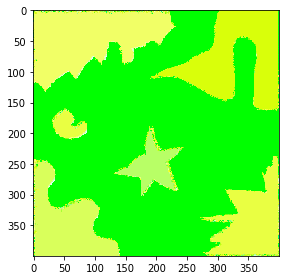

In [20]:
imshow(Dm, cmap='hsv')

In [21]:
imsave('Finalresult.png',Dm)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [22]:
Left = np.zeros((height, width, 3))
Right = np.zeros((height, width, 3))
Up = np.zeros((height, width, 3))
Down = np.zeros((height, width, 3))

for y in range(0, height):
        for x in range(0, width):
            
            best_d = D[Res[y,x]]
            
            if best_d[0] >= 0:
                Up[y,x,0] = best_d[0]
                Up[y,x,1] = best_d[0]
            else:
                Down[y,x,1] = abs(best_d[0])
               
            if best_d[1] >= 0:
                Left[y,x,0] = best_d[1]
            else:
                Right[y,x,2] = abs(best_d[1])
    
max_disp = max( np.max(np.array(Dx)), np.max(np.array(Dy)))
Left = (Left*(255.0/max_disp)).astype(np.int16)  
Right = (Right*(255.0/max_disp)).astype(np.int16)  
Up = (Up*(255.0/max_disp)).astype(np.int16)  
Down = (Down*(255.0/max_disp)).astype(np.int16)  

/home/support/.local/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


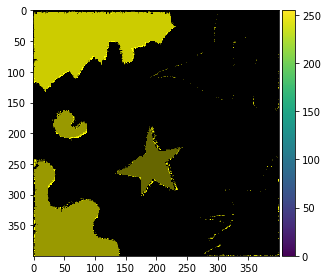

In [23]:
imshow(Up)

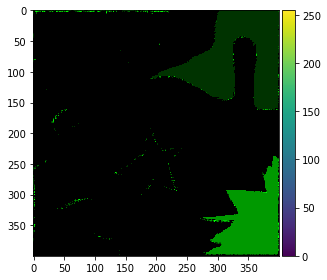

In [24]:
imshow(Down)

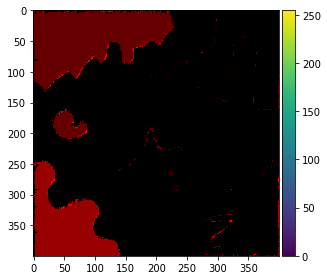

In [25]:
imshow(Left)

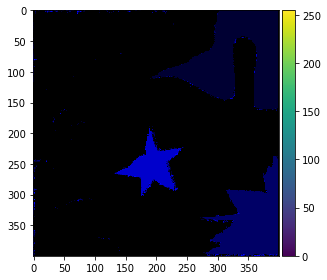

In [26]:
imshow(Right)

In [27]:
imsave('Up.png',Up)
imsave('Down.png',Down)
imsave('Left.png',Left)
imsave('Right.png',Right)

<ipython-input-27-6f2e7a3d068d>:1: UserWarning: Up.png is a low contrast image
  imsave('Up.png',Up)
Lossy conversion from int16 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-27-6f2e7a3d068d>:2: UserWarning: Down.png is a low contrast image
  imsave('Down.png',Down)
Lossy conversion from int16 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-27-6f2e7a3d068d>:3: UserWarning: Left.png is a low contrast image
  imsave('Left.png',Left)
Lossy conversion from int16 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-27-6f2e7a3d068d>:4: UserWarning: Right.png is a low contrast image
  imsave('Right.png',Right)
Lossy conversion from int16 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
